In [2]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from torch_npu.contrib import transfer_to_npu
import torch_npu
from anndata import AnnData
import scanpy as sc
import numpy as np

# %matplotlib agg
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
# import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import ricefm as rfm
from ricefm.tasks import GeneEmbedding
from ricefm.tokenizer.gene_tokenizer import GeneVocab
from ricefm.model.model_main import TransformerModel
from ricefm.preprocess import Preprocessor
from ricefm.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/root/anaconda3/envs/scgpt_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/scgpt_new/lib/python3.10/site-packages/torch_npu/dynamo/__init__.py:18: UserWarning: Register eager implementation for the 'npu' backend of dynamo, as torch_npu was not compiled with torchair.
  warnings.warn(
/root/anaconda3/envs/scgpt_new/lib/python3.10/site-packages/torch_npu/contrib/transfer_to_npu.py:164: ImportWarning: 
    *************************************************************************************************************
    The torch.Tensor.cuda and torch.nn.Module.cuda are replaced with torch.Tensor.npu and torch.nn.Module.npu now..
    The torch.cuda.DoubleTensor is replaced with torch.npu.FloatTensor cause the double type is not supported now..
    The backend in torch.distributed.ini

In [3]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [4]:
# Specify model path; here we load the pre-trained scGPT blood model
model_dir = Path("/root/riceFM_save/eval-Nov05-18-46-2025")
# model_dir = Path("/share/home/bgi_clicx/plant_ST/save/eval-Jul20-18-18-2025")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /root/riceFM_save/eval-Nov05-18-46-2025/best_model.pt, the model args will override the config /root/riceFM_save/eval-Nov05-18-46-2025/args.json.


In [ ]:
device = torch.device("npu:0" if torch.npu.is_available() else "cpu")
torch.npu.set_device(device)

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([40158, 256])
Loading params encoder.enc_norm.weight with shape torch.Size([256])
Loading params encoder.enc_norm.bias with shape torch.Size([256])
Loading params value_encoder.linear1.weight with shape torch.Size([256, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([256])
Loading params value_encoder.linear2.weight with shape torch.Size([256, 256])
Loading params value_encoder.linear2.bias with shape torch.Size([256])
Loading params value_encoder.norm.weight with shape torch.Size([256])
Loading params value_encoder.norm.bias with shape torch.Size([256])
Loading params mod_encoder.embedding.weight with shape torch.Size([2, 256])
Loading params mod_encoder.enc_norm.weight with shape torch.Size([256])
Loading params mod_encoder.enc_norm.bias with shape torch.Size([256])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([256, 256])
Loading params transformer_encoder

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(40158, 256, padding_idx=40155)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=256, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (mod_encoder): ModEncoder(
    (embedding): Embedding(2, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.5,

In [6]:
input_gene_list = [
    "ZH03G26960",
    "ZH04G16480",
    "ZH07G00370",
    "ZH08G06020",
    "ZH12G03480",
    "ZH03G09740",
    "ZH07G20840",
    "ZH03G18750",
    "ZH05G32200",
    "ZH01G09250",
    "ZH09G17120",
    "ZH08G26300",
    "ZH03G19050",
    "ZH05G08380",
    "ZH12G15110",
    "ZH02G19910",
    "ZH05G19820",
    "ZH01G44680",
    "ZH11G16520",
    "ZH01G25380",
    "ZH02G14620",
]

gene_name_list = [
    "OsMST2",
    "OsMST1",
    "OsMST3",
    "OsMST5",
    "OsMST8",
    "OsMST4",
    "OsMST6",
    "SWEET16",
    "SWEET5",
    "SWEET3b",
    "SWEET11b",
    "SWEET11",
    "SWEET12",
    "SWEET3a",
    "SWEET13",
    "SWEET15",
    "SWEET1b",
    "SWEET1a",
    "SWEET14",
    "SWEET6b",
    "SWEET4",
]
    

In [7]:
input_gene_ids = np.array(vocab(input_gene_list), dtype=int)


In [8]:
# mod_type_embs = model.mod_encoder(torch.tensor(0).to(device))
gene_id_embs = model.encoder(torch.tensor(input_gene_ids, dtype=torch.long).to(device))  # (batch, pcpt_len, embsize)
# gene_embeddings = gene_id_embs + mod_type_embs
gene_embeddings = gene_id_embs
gene_embeddings = gene_embeddings.detach().cpu().numpy()
gene_embeddings = {gene_name_list[i]: gene_embeddings[i] for i, gene in enumerate(input_gene_list) if gene in input_gene_list}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 21 genes.


In [9]:
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 21/21 [00:00<00:00, 180123.48it/s]


In [10]:
CD_genes = gene_name_list
# CD_genes = mgs['14']
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = pd.concat([df_CD, df], ignore_index=True)
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

100%|██████████| 21/21 [00:00<00:00, 51.92it/s]


In [11]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

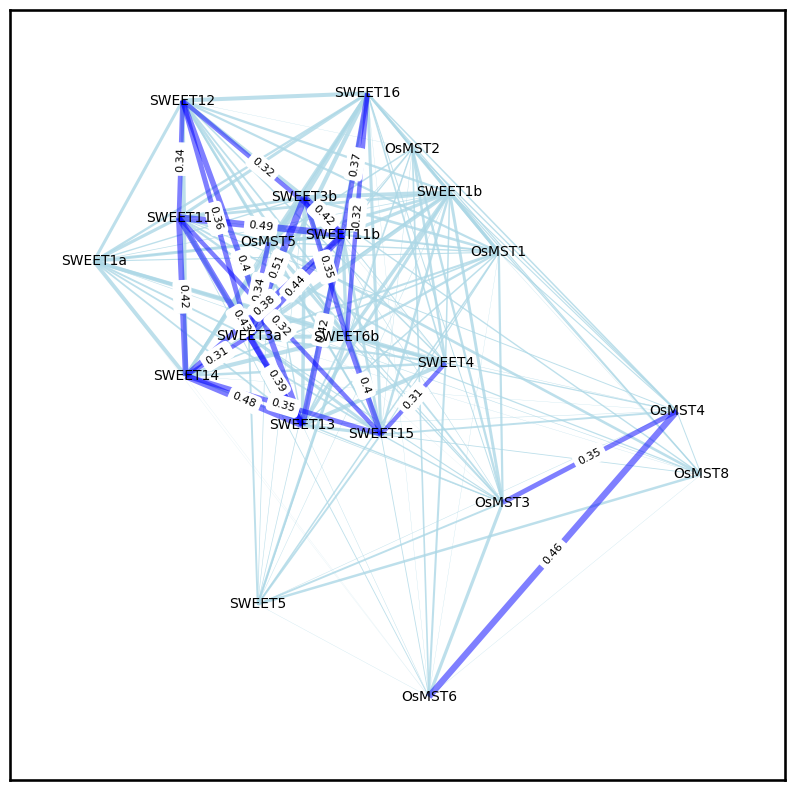

In [16]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.3
plt.figure(figsize=(10, 10))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "blue", 
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

ax = plt.gca()
ax.margins(0.08)
# plt.axis("off")
# plt.title("Cluster2 > "+str(thresh),size=30)
plt.savefig("/root/riceFM/tutorials/save/GRN/tang.png", dpi=300, bbox_inches='tight')
plt.show()